# Objectives

- Predict customers' likelihood of default using relevant data 
- Suggest how customers can be segmented, so the bank can focus its resources on higher-priority customers 


# Section 1: Classification Model (predict defaulters)

In [1]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import cross_validate, cross_val_score


from hyperopt import hp, Trials, tpe, fmin, space_eval, STATUS_OK
from hyperopt.early_stop import no_progress_loss



In [2]:
# import data
df = pd.read_excel('data/credit card_defaults.xlsx')

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment this month
0,1,20000,2,2,1,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
BILL_AMT1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
BILL_AMT2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
BILL_AMT3,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
BILL_AMT4,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   BILL_AMT1                   30000 non-null  int64
 7   BILL_AMT2                   30000 non-null  int64
 8   BILL_AMT3                   30000 non-null  int64
 9   BILL_AMT4                   30000 non-null  int64
 10  BILL_AMT5                   30000 non-null  int64
 11  BILL_AMT6                   30000 non-null  int64
 12  PAY_AMT1                    30000 non-null  int64
 13  PAY_AMT2                    30000 non-null  int64
 14  PAY_AM

In [6]:
# check for missing values: no missing values

df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment this month    0
dtype: int64

In [7]:
# check for duplicates

df.duplicated().sum()

0

## EDA

In [8]:
# sns.pairplot(df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'default payment this month']], diag_kind='hist', diag_kws={'color':'r'});

default payment this month
0    77.88
1    22.12
Name: proportion, dtype: float64


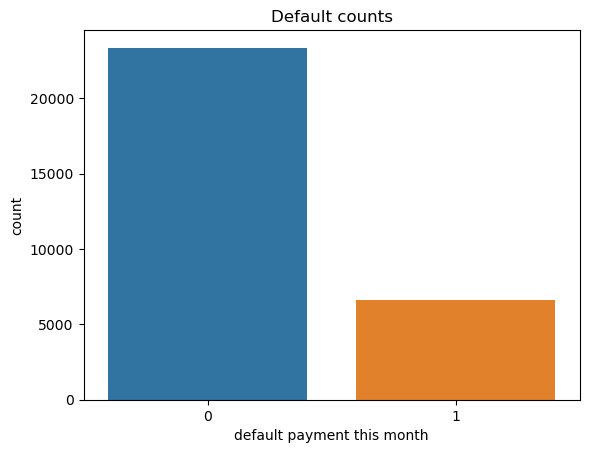

In [9]:
# default percentage of population

sns.countplot(x=df['default payment this month'])
plt.title('Default counts')

print(df['default payment this month'].value_counts(normalize=True)*100)

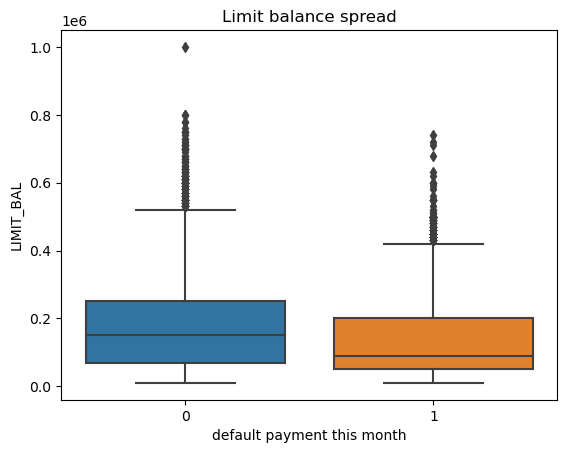

In [10]:
sns.boxplot(x='default payment this month', y='LIMIT_BAL', data=df)
plt.title('Limit balance spread');

# Defaulters have a lower limit balance

In [11]:
df['EDUCATION'].value_counts()

# values 5,6,0 are not in data dictionary

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

In [12]:
# Recategorize values not in data dictionary to 'Others'

df['EDUCATION'].value_counts()

df.loc[df['EDUCATION'] == 5, 'EDUCATION'] = 4
df.loc[df['EDUCATION'] == 6, 'EDUCATION'] = 4
df.loc[df['EDUCATION'] == 0, 'EDUCATION'] = 4

In [13]:
df['MARRIAGE'].value_counts()

# values 0 are not in data dictionary

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

In [14]:
# Recategorize values not in data dictionary to 'Others'

df['MARRIAGE'].value_counts()

df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3


## Feature Engineering

To create these features:

- Total bill amount
- Total payment amount
- Mean payment amount
- Mean bill amount
- Ratio of total payment / total bill amount
- Ratio of PAY_AMT1 / BILL_AMT1 (this helps to see whether they've fully paid their latest bill)


In [15]:
df['TOTAL_BILL_AMT'] = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']
df['TOTAL_PAY_AMT'] = df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6'] 

df['MEAN_PAY_AMT'] = df['TOTAL_PAY_AMT'] / 6
df['MEAN_BILL_AMT'] = df['TOTAL_BILL_AMT'] / 6


# Ratio of Total Pay/Total Bill, if Total Bill is zero, then take Total Pay; prevent division by zero 
df['TOTAL_PAY/TOTAL_BILL'] = np.where(df['TOTAL_BILL_AMT']==0, df['TOTAL_PAY_AMT'], df['TOTAL_PAY_AMT'] / df['TOTAL_BILL_AMT']) # This is better
# df['TOTAL_BILL/TOTAL_PAY'] = np.where(df['TOTAL_PAY_AMT']==0, df['TOTAL_BILL_AMT'], df['TOTAL_BILL_AMT'] / df['TOTAL_PAY_AMT']) 

# Ratio of Pay AMT1 / Bill AMT1; prevent division by zero
df['PAY_AMT1/BILL_AMT1'] = np.where(df['BILL_AMT1']==0, df['PAY_AMT1'], df['PAY_AMT1'] / df['BILL_AMT1']) # This is better
# df['BILL_AMT1/PAY_AMT1'] = np.where(df['PAY_AMT1']==0, df['BILL_AMT1'], df['BILL_AMT1'] / df['PAY_AMT1'])


# df['MEAN_PAY/MEAN_BILL'] = np.where(df['MEAN_BILL_AMT']==0, df['MEAN_PAY_AMT'], df['MEAN_PAY_AMT'] / df['MEAN_BILL_AMT']) # f1 decreased but accuracy, roc, avg prec improved
# df['MEAN_BILL/MEAN_PAY'] = np.where(df['MEAN_PAY_AMT']==0, df['MEAN_BILL_AMT'], df['MEAN_BILL_AMT'] / df['MEAN_PAY_AMT'])


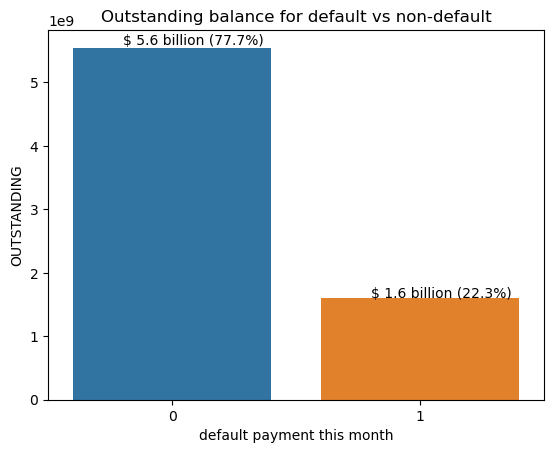

In [16]:
# Calculate outstanding balance for defaulters and non-defaulters

df['OUTSTANDING'] = df['TOTAL_BILL_AMT'] - df['TOTAL_PAY_AMT']

# group into defaulters and non-defaulters
grp0 = df.groupby('default payment this month').get_group(0)
grp1 = df.groupby('default payment this month').get_group(1)

# Calculate outstanding sum for default and non-default, take only the positives, because some are -ve
outstanding0 = grp0.loc[grp0['OUTSTANDING'] >= 0, 'OUTSTANDING'].sum()
outstanding1 = grp1.loc[grp1['OUTSTANDING'] >= 0, 'OUTSTANDING'].sum()


# Calculate percentages
outstanding0_percent = round(outstanding0 / (outstanding0 + outstanding1) * 100,2)
outstanding1_percent = round(outstanding1 / (outstanding0 + outstanding1) * 100,2)

# Plot bar chart
sns.barplot(data=df.groupby('default payment this month')['OUTSTANDING'].sum().reset_index(), x='default payment this month', y='OUTSTANDING');
plt.text(-0.2, outstanding0, f'${outstanding0 / 1e9: .1f} billion ({outstanding0_percent:.1f}%)')
plt.text(0.8, outstanding1, f'${outstanding1 / 1e9: .1f} billion ({outstanding1_percent:.1f}%)');
plt.title('Outstanding balance for default vs non-default');

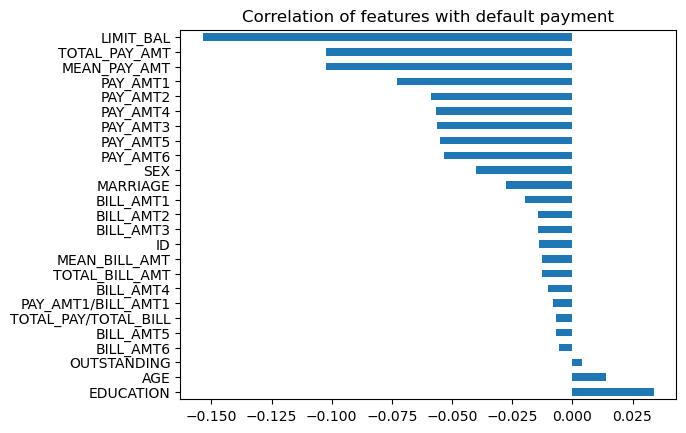

In [17]:
df.corr()['default payment this month'].sort_values(ascending=False)[1:].plot(kind='barh')
plt.title('Correlation of features with default payment');

# Limit balance, and payment amounts have high -ve correlation with 'default payment this month'.
# PAY_AMT1 seems to be more recent than PAY_AMT2, and so on.

## Feature Selection

In [18]:
cols_to_drop = [
                # 'SEX', 'AGE', 
                # "MARRIAGE", 
                'MEAN_PAY_AMT', 'MEAN_BILL_AMT', # can drop these for slight increase in ROC and F1 for xgb
                'OUTSTANDING',    # low correlation with default flag
                # 'BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4', 
                # 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1', 
                # 'PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4', 
                # 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1',
               ]

features_df = df.drop(columns=cols_to_drop)



In [19]:
# Train test split

X = features_df.drop(['default payment this month'], axis=1)
y = features_df['default payment this month']

X_train_w_id, X_test_w_id, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Drop ID from model training

X_train = X_train_w_id.drop('ID', axis=1)
X_test = X_test_w_id.drop('ID', axis=1)

X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'TOTAL_BILL_AMT', 'TOTAL_PAY_AMT', 'TOTAL_PAY/TOTAL_BILL',
       'PAY_AMT1/BILL_AMT1'],
      dtype='object')

## Classification model training

In [21]:
# Function for printing out metrics

def print_metrics(preds, preds_proba, model_name):

    print('accuracy:', accuracy_score(y_test, preds))
    print('f1 score:', f1_score(y_test, preds))
    print('roc_auc:', roc_auc_score(y_test, preds_proba))
    print('average precision:', average_precision_score(y_test, preds_proba))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(f'Metrics for {model_name}')

### Random Forest model with hyperopt search

 87%|██████ | 61/70 [04:26<00:39,  4.36s/trial, best loss: -0.24468181628086166]


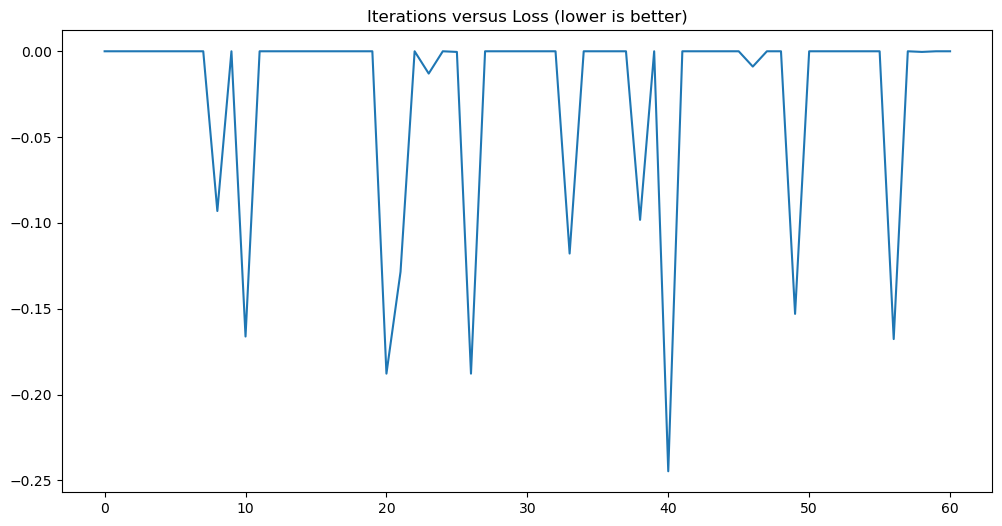

In [22]:
# Random Forest model

forest_params = {
    'n_estimators': hp.choice('n_estimators',[300, 400, 500]),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'max_features': hp.choice('max_features', ["sqrt", "log2"]),
    'class_weight': hp.choice('class_weight', [{0:1, 1:1.1}, {0:1, 1:1.15}, {0:1, 1:1.2}]),
    'min_weight_fraction_leaf': hp.quniform('min_weight_fraction_leaf', 0, 0.5, 0.01),
    'random_state': 42
}


def forest_objective(params):
    
    forest = RandomForestClassifier(
        n_estimators = params['n_estimators'],
        max_depth = int(params['max_depth']),
        max_features = params['max_features'],
        class_weight = params['class_weight'],
        min_weight_fraction_leaf = params['min_weight_fraction_leaf'],
        random_state = params['random_state']
    )
    
    # 2-fold cv to be faster    
    score_array = cross_val_score(forest, X_train, y_train, scoring='f1', cv=2)
    score = score_array.mean()

    # -ve because fmin seeks to minimize loss => smallest number, and we want highest acc score
    return -score


trials = Trials()

best_forest_search = fmin(forest_objective, forest_params, algo=tpe.suggest, max_evals=70, trials=trials, early_stop_fn=no_progress_loss(20))

# Plot loss against no. of iterations
pd.DataFrame(trials.results)['loss'].plot(figsize=(12,6))
plt.title('Iterations versus Loss (lower is better)');



accuracy: 0.7885
f1 score: 0.2441929720071471
roc_auc: 0.7254665275491787
average precision: 0.43330847095496494


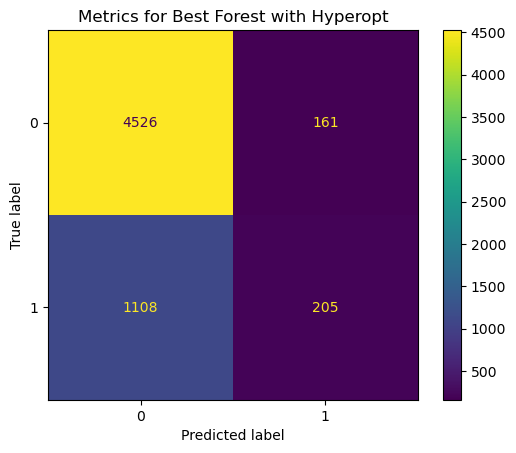

In [23]:
best_forest_params = space_eval(forest_params, best_forest_search)

best_forest = RandomForestClassifier(
        n_estimators = best_forest_params['n_estimators'],
        max_depth = int(best_forest_params['max_depth']),
        max_features = best_forest_params['max_features'],
        class_weight = best_forest_params['class_weight'],
        min_weight_fraction_leaf = best_forest_params['min_weight_fraction_leaf'],
        random_state = best_forest_params['random_state']
    )

best_forest.fit(X_train, y_train)

preds_forest = best_forest.predict(X_test)
preds_proba_forest = best_forest.predict_proba(X_test)[:,1]

print_metrics(preds_forest, preds_proba_forest, 'Best Forest with Hyperopt')

### XGB with hyperopt search

100%|████████| 90/90 [07:13<00:00,  4.82s/trial, best loss: -0.4346515782491976]


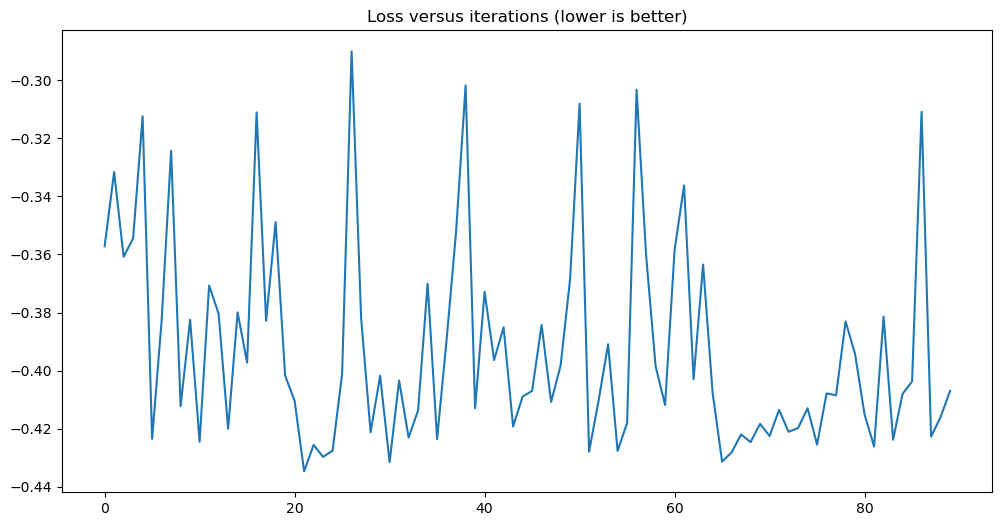

In [67]:
# xgboost with hyperparameter tuning

from hyperopt import hp, Trials, tpe, fmin, space_eval
from sklearn.model_selection import cross_validate, cross_val_score
from hyperopt.early_stop import no_progress_loss


search_params = {'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.016)),
                 'n_estimators': 400,
                 'max_depth': hp.quniform('max_depth', 5, 11, 1),
                 'colsample_bylevel': 1,
                 'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.1),
                 'max_delta_step': hp.quniform('max_delta_step', 0, 9, 1), # More conservative update step
                 # 'min_child_weight': hp.quniform('min_child_weight', 0, 5, 1), #  Minimum sum of instance weight (hessian) needed in a child. The larger min_child_weight is, the more conservative the algorithm will be.
                 'gamma': hp.uniform('gamma', 2, 7), # Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. (0 to inf)
                 'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 1.8), # handle class imbalance
                 'seed': 42,
                 'subsample': hp.quniform('subsample', 0.4, 1, 0.1),
                 # 'reg_alpha': hp.uniform('reg_alpha', 0, 1), # L1 regularization (can shrink coeffs to 0)
                 # 'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                }


# Define xgboost objective function
def objective(params):
        
    xgb_model = xgb.XGBClassifier(
        objective= 'binary:logistic',
        learning_rate= params['learning_rate'],
        n_estimators = int(params['n_estimators']),
        max_depth = int(params['max_depth']),
        colsample_bytree = params['colsample_bytree'],
        colsample_bylevel = params['colsample_bylevel'],
        max_delta_step = params['max_delta_step'],
        # min_child_weight = params['min_child_weight'],
        gamma = params['gamma'], 
        scale_pos_weight = params['scale_pos_weight'],
        seed = params['seed'],
        subsample = params['subsample'],
        # reg_alpha = params['reg_alpha'],
        # reg_lambda = params['reg_lambda'],
    )

    # 2-fold cv     
    score_array = cross_val_score(xgb_model, X_train, y_train, scoring='f1', cv=2)
    score = score_array.mean()

    # -ve score because fmin seeks to minimize loss => smallest number, and we want highest acc score
    return -score


trials = Trials()

# best = fmin(objective, search_params, algo=tpe.suggest, max_evals=70, trials=trials, early_stop_fn=no_progress_loss(10))
best = fmin(objective, search_params, algo=tpe.suggest, max_evals=90, trials=trials)


# Plot loss against no. of iterations
pd.DataFrame(trials.results)['loss'].plot(figsize=(12,6))
plt.title('Loss versus iterations (lower is better)');



accuracy: 0.787
f1 score: 0.4206708975521306
roc_auc: 0.7371810444243782
average precision: 0.4471831981443244


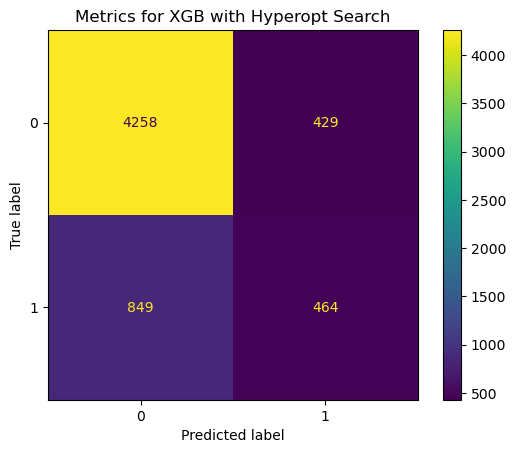

In [25]:
# XGBoost - Get best params and fit the model, generate test predictions

best_params = space_eval(search_params, best)

xgb_model = xgb.XGBClassifier(learning_rate=best_params['learning_rate'],
                    objective= 'binary:logistic',
                    n_estimators=int(best_params['n_estimators']),
                    max_depth=int(best_params['max_depth']),
                    colsample_bytree = best_params['colsample_bytree'],
                    colsample_bylevel = best_params['colsample_bylevel'],
                    max_delta_step = best_params['max_delta_step'],
                    # min_child_weight = best_params['min_child_weight'],
                    gamma = best_params['gamma'],
                    scale_pos_weight = best_params['scale_pos_weight'],
                    seed=best_params['seed'],
                    subsample = best_params['subsample'],
                    # reg_alpha = best_params['reg_alpha'],
                    # reg_lambda = best_params['reg_lambda'],
                   )

xgb_model.fit(X_train, y_train)


# Get predictions
y_preds_xg = xgb_model.predict(X_test)
y_preds_proba_xg = xgb_model.predict_proba(X_test)[:,1]

print_metrics(y_preds_xg, y_preds_proba_xg, 'XGB with Hyperopt Search')

In [68]:
space_eval(search_params , best)

{'colsample_bylevel': 1,
 'colsample_bytree': 0.7000000000000001,
 'gamma': 4.5558630933753905,
 'learning_rate': 0.013593146776528722,
 'max_delta_step': 9.0,
 'max_depth': 7.0,
 'n_estimators': 400,
 'scale_pos_weight': 1.7987618533155987,
 'seed': 42,
 'subsample': 0.6000000000000001}

## Best XGB params recorded from previous searches

accuracy: 0.7845
f1 score: 0.4240534521158129
roc_auc: 0.7366175925990622
average precision: 0.44917061634345246


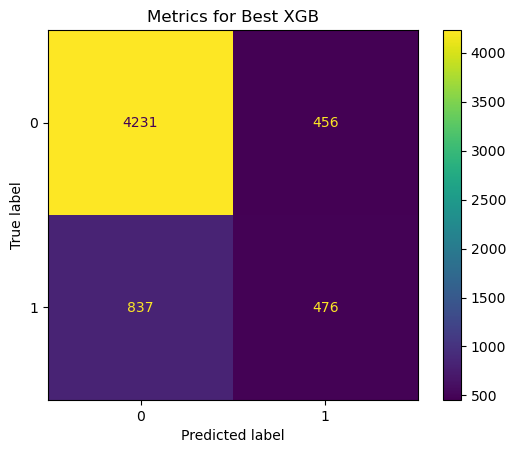

In [22]:
# Best params based on previous searches

# for better accuracy use this:
# best_params = {'colsample_bylevel': 1.0, 
#  'colsample_bytree': 0.4,
#  'gamma': 4.621243558517659,
#  'learning_rate': 0.014582171926585737,
#  'max_delta_step': 2.0,
#  'max_depth': 9.0,
#  'n_estimators': 400,
#  'scale_pos_weight': 1.3789605768118396,
#  'seed': 42
# }

# Better F1 score gives more collection in this case (imbalanced classes)
best_params = {'colsample_bylevel': 1,
 'colsample_bytree': 0.7000000000000001,
 'gamma': 5.184785207039868,
 'learning_rate': 0.013813902138745884,
 'max_delta_step': 3.0,
 'max_depth': 7.0,
 'n_estimators': 400,
 'scale_pos_weight': 1.7828279949465282,
 'seed': 42,
 'subsample': 0.9}


xgb_model = xgb.XGBClassifier(learning_rate=best_params['learning_rate'],
                    objective= 'binary:logistic',
                    n_estimators=int(best_params['n_estimators']),
                    max_depth=int(best_params['max_depth']),
                    colsample_bytree = best_params['colsample_bytree'],
                    colsample_bylevel = best_params['colsample_bylevel'],
                    scale_pos_weight = best_params['scale_pos_weight'],
                    seed=best_params['seed'],
                    # min_child_weight = best_params['min_child_weight'],
                    subsample = best_params['subsample'],
                    # reg_alpha = best_params['reg_alpha'],
                    # reg_lambda = best_params['reg_lambda'],
                    max_delta_step = best_params['max_delta_step'],
                    gamma = best_params['gamma'],
                   )

xgb_model.fit(X_train, y_train)

y_preds_xg = xgb_model.predict(X_test)
y_preds_proba_xg = xgb_model.predict_proba(X_test)[:,1]

print_metrics(y_preds_xg, y_preds_proba_xg, 'Best XGB')

## Check feature importances for models

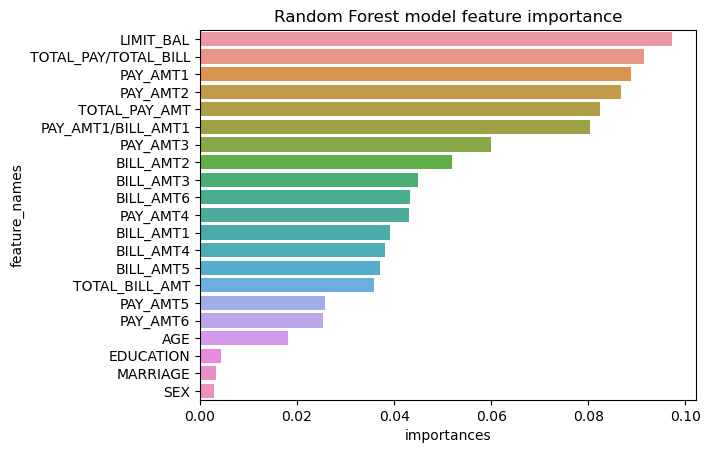

In [28]:
importances = best_forest.feature_importances_
feature_names = best_forest.feature_names_in_

importance_df = pd.DataFrame({'feature_names': feature_names, 'importances': importances})
importance_df.sort_values(by='importances', ascending=False, inplace=True)

sns.barplot(y='feature_names', x='importances',data=importance_df)
plt.title('Random Forest model feature importance');

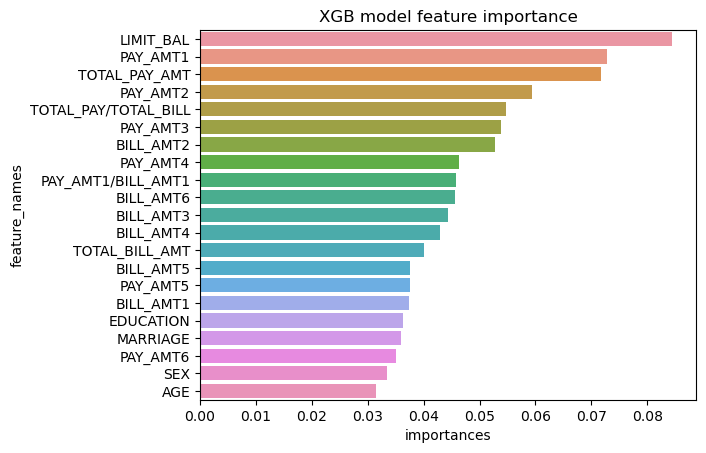

In [29]:
importances = xgb_model.feature_importances_
feature_names = xgb_model.feature_names_in_

importance_df = pd.DataFrame({'feature_names': feature_names, 'importances': importances})
importance_df.sort_values(by='importances', ascending=False, inplace=True)

sns.barplot(y='feature_names', x='importances',data=importance_df)
plt.title('XGB model feature importance');

## Prioritize customers using XGB Model
Using the XGB model because it has better performance (higher f1 score and average precision).

Calculate customers' default priority where:  
<mark>default importance = likelihood of default * outstanding amount (from past 6 months)</mark>

In [30]:

# Use model to predict customers default probabilities on X_test
predict_proba = xgb_model.predict_proba(X_test)

# We will be using X_test_w_id for cluster segmentation

# Make a copy first
default_df = X_test_w_id.copy()

# Add true labels back to default_df for clustering evaluation later
default_df['default payment this month'] = y_test

default_df['DEFAULT_PROBA'] = predict_proba[:,1] # get class 1 probabilities

# Outstanding debt
default_df['OUTSTANDING'] = default_df['TOTAL_BILL_AMT'] - default_df['TOTAL_PAY_AMT']


# Importance of defaulting = Outstanding * Default Probability
default_df['DEFAULT_IMPORTANCE'] = round(default_df['OUTSTANDING'] * default_df['DEFAULT_PROBA'], 2)

# Sort users by Default Importance
default_df.sort_values(by='DEFAULT_IMPORTANCE', ascending=False)[['ID', 'DEFAULT_IMPORTANCE']].head(20)

# Top 20 customers sorted based on default importance


,ID,DEFAULT_IMPORTANCE
15593,15594,1906146.43
4336,4337,1891032.60
27263,27264,1843504.91
13561,13562,1685870.15
29605,29606,1675408.47
24937,24938,1627517.98
17795,17796,1475224.92
15382,15383,1403935.60
4408,4409,1262523.96
29011,29012,1189901.62


## Gain Lift Chart

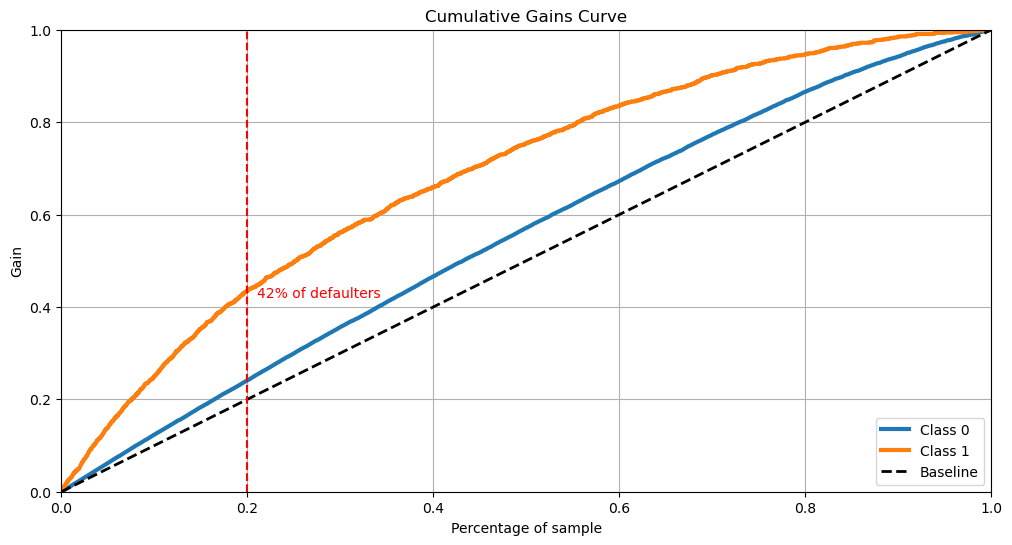

In [31]:
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

plot_cumulative_gain(y_test, predict_proba, figsize=(12,6));

# red line to indicate 40% mark
plt.axvline(x=0.2, color='r', linestyle='--')
plt.text(0.21, 0.42, '42% of defaulters', color='r');

#### <mark> Based on the cumulative gains curve, if we can target top 20% of the observations, the XGB model will ensure that 42% of the defaulters (Class 1) in total are captured, while random pick (Baseline) would provide only 20%. </mark>

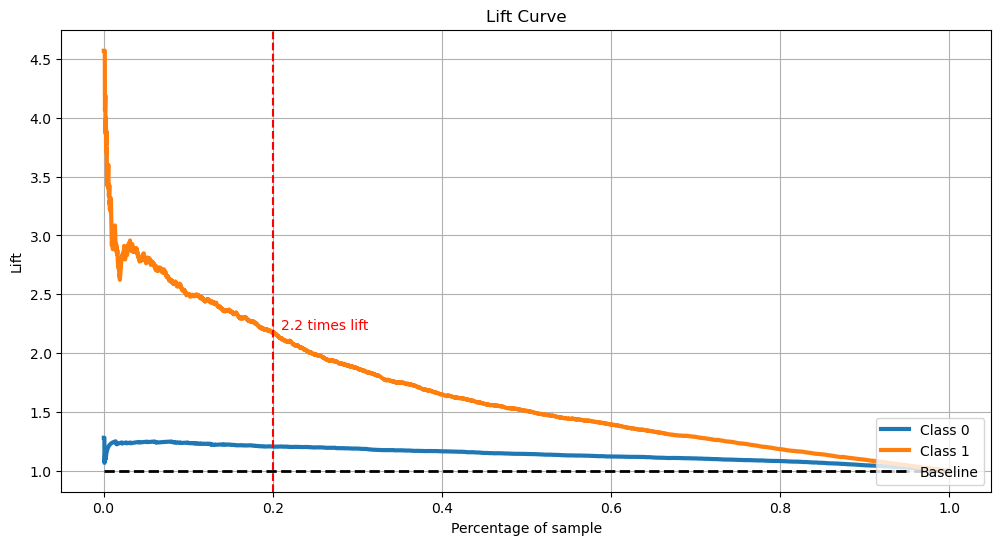

In [32]:
plot_lift_curve(y_test, predict_proba, figsize=(12,6))

# red line to indicate 30% mark
plt.axvline(x=0.2, color='r', linestyle='--')
plt.text(0.21, 2.2, '2.2 times lift', color='r');

#### <mark>At the top 20% (probability) of observations, the model provides a lift of 2.2 (estimated). Thus, the model allows addressing 2.2 times more defaulters, compared to random (without model).</mark>


------------------------

# Section 2: User Segmentation

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import metrics

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

## EDA and visualization

In [34]:
default_df.describe()[['DEFAULT_PROBA', 'DEFAULT_IMPORTANCE']]

# The top 25% for default probability is above 0.33

,DEFAULT_PROBA,DEFAULT_IMPORTANCE
count,6000.000000,6.000000e+03
mean,0.305452,7.327480e+04
std,0.176159,1.344288e+05
min,0.030883,-1.803049e+05
25%,0.173680,1.017135e+03
50%,0.266757,2.850578e+04
75%,0.390501,8.827076e+04
max,0.927421,1.906146e+06


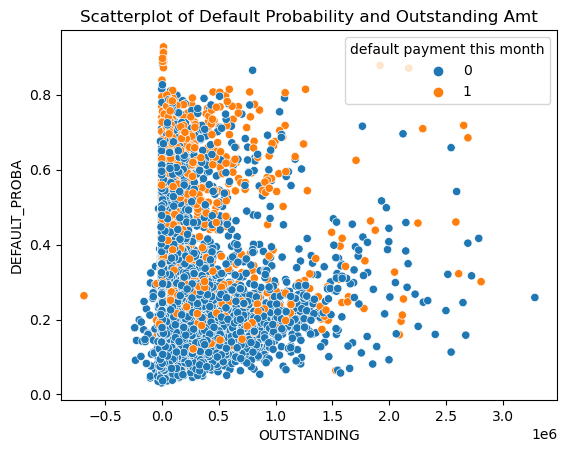

In [35]:
sns.scatterplot(data=default_df, x='OUTSTANDING', y='DEFAULT_PROBA', hue='default payment this month')

plt.title('Scatterplot of Default Probability and Outstanding Amt');

# Seems like high default proba has more defaulters, which makes sense because it's generated by predictive model

## Feature selection for clustering

In [36]:
cols_for_clustering = [ 
                    'DEFAULT_IMPORTANCE', # = Default Proba * Outstanding
                    'LIMIT_BAL', 
                    # 'DEFAULT_PROBA', 
                    # 'OUTSTANDING',    
                    # 'EDUCATION', 
                    # 'AGE'
                    # 'MARRIAGE',
                    # 'SEX', 
                      ]

cluster_df = default_df[cols_for_clustering]

cluster_df.head()

,DEFAULT_IMPORTANCE,LIMIT_BAL
2308,24328.59,30000
22404,88067.69,150000
23397,136758.03,70000
25058,12469.18,130000
2664,88707.76,50000


In [37]:
# One hot encoding, if we are going to use those features. But for now, no.

# cluster_df_encoded = pd.get_dummies(cluster_df, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True, dtype=int)

# cluster_df_encoded.head()

In [38]:
# Scaling / Standardization

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

cols_to_scale = cols_for_clustering

# Scale the columns
cluster_df_scaled = cluster_df.copy()
cluster_df_scaled[cols_to_scale] = scaler.fit_transform(cluster_df[cols_to_scale])

# Assign weights to columns
weights = np.array([4, 1]) # Weightage affects silhouette score of clusters and collected sum

cluster_df_scaled = cluster_df_scaled * weights



In [39]:
cluster_df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
DEFAULT_IMPORTANCE,6000.0,0.486145,0.257718,0.0,0.347618,0.400317,0.514895,4.0
LIMIT_BAL,6000.0,0.200652,0.164309,0.0,0.050633,0.164557,0.291139,1.0


## K-Means clustering (to find optimal cluster number)




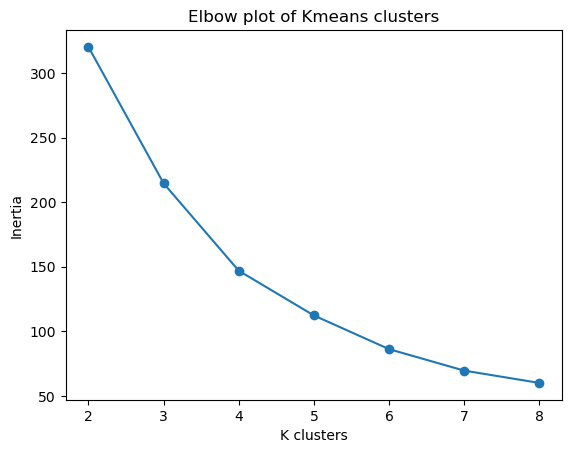

In [40]:
# Find the optimum clusters using an elbow plot

errors = {}
silhouette_scores = {}

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cluster_df_scaled)
    errors[k] = kmeans.inertia_
    y_pred = kmeans.predict(cluster_df_scaled)
    silhouette_scores[k] = silhouette_score(cluster_df_scaled, y_pred)

plt.plot(errors.keys(), errors.values(), marker='o')
plt.xlabel('K clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot of Kmeans clusters');

# based on plot below, 2-3 clusters?

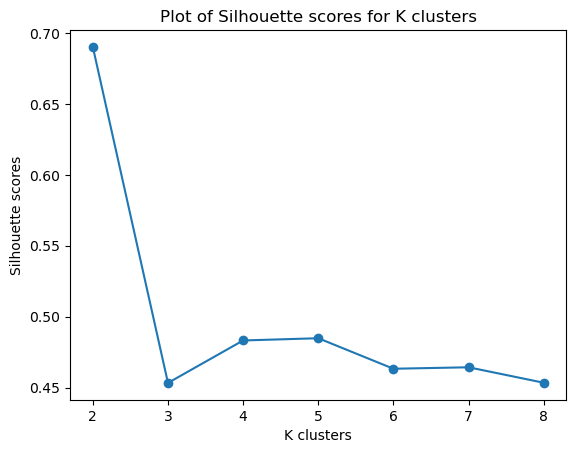

In [41]:
plt.plot(silhouette_scores.keys(), silhouette_scores.values() , marker='o');
plt.xlabel('K clusters')
plt.ylabel('Silhouette scores')
plt.title('Plot of Silhouette scores for K clusters');

# between -1 to 1, higher is better

Based on the elbow plot and silhouette scores, the optimal clusters seems to be 2 or 3.

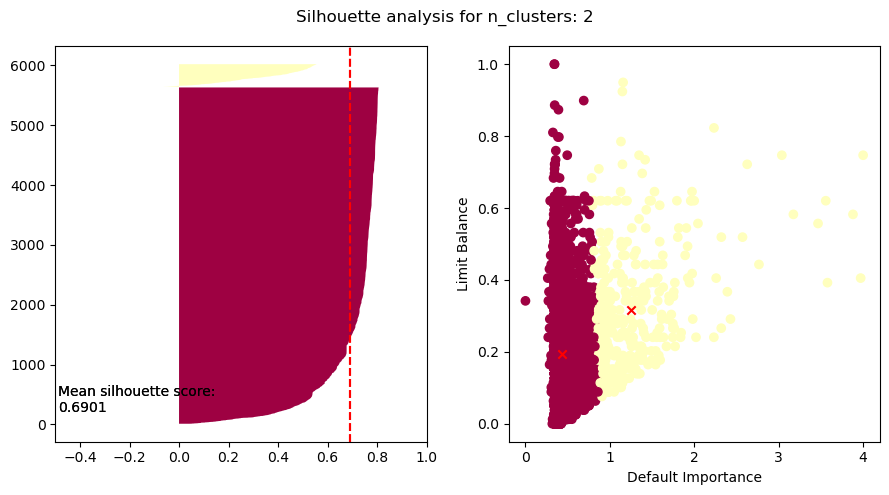

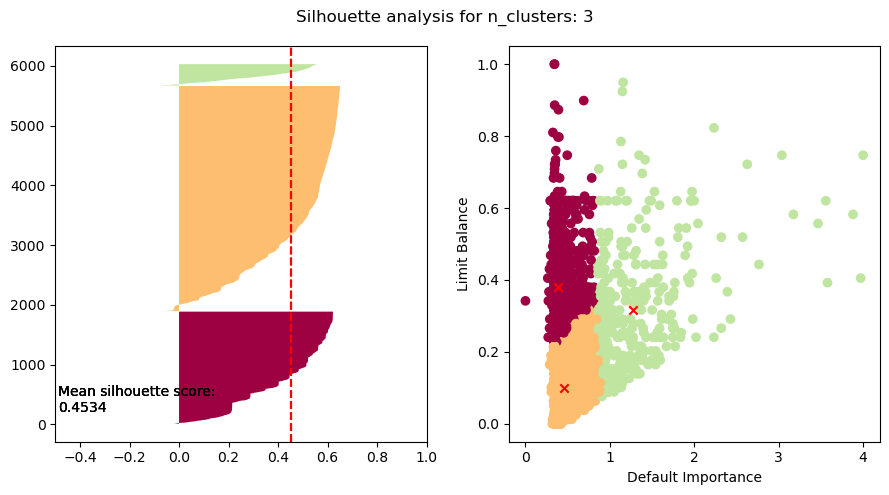

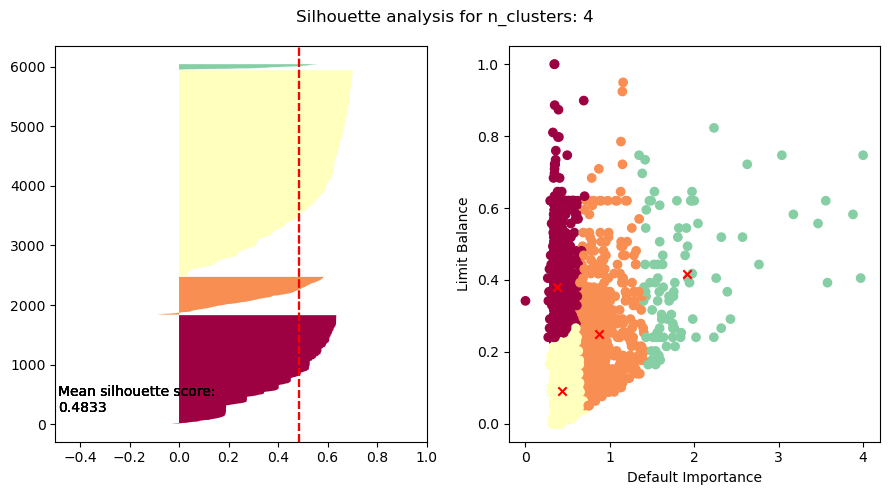

In [42]:
for k in range(2,5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cluster_df_scaled)
    labels = kmeans.predict(cluster_df_scaled)
    centroids = kmeans.cluster_centers_

    sil_samp = silhouette_samples(cluster_df_scaled, labels)
    sil_overall = silhouette_score(cluster_df_scaled, labels)

    y_lower = 10
    
    plt.figure(figsize=(9,5))
    plt.suptitle(f'Silhouette analysis for n_clusters: {k}')

    # for each cluster in total K clusters
    for n in range(k):    
        
        # get coeff scores for the n cluster
        sil_coeff = sil_samp[labels == n]
        sil_coeff.sort() # sort for small to large
        y_upper = y_lower + len(sil_coeff)
        
        # get number of points in that cluster
        y_points = np.linspace(y_lower, y_upper, len(sil_coeff))
        
        
        plt.subplot(1, 2, 1)
        plt.xlim(-.5, 1)
        plt.annotate(f'Mean silhouette score: \n' + str(sil_overall.round(4)), (-0.49, 200))

        cmap = plt.get_cmap("Spectral")
        color = cmap(float(n)/k)
        plt.fill_betweenx(y_points, sil_coeff, facecolor=color)
        plt.axvline(x = sil_overall, linestyle='--', c='r')
        
        y_lower = y_upper + 10 # set the lower limit for the next cluster
        
    plt.subplot(1, 2, 2)
    colors = cmap(labels.astype(float)/k)
    plt.scatter(cluster_df_scaled.iloc[:,0], cluster_df_scaled.iloc[:,1], c=colors)
    plt.xlabel('Default Importance')
    plt.ylabel('Limit Balance')
    
    # plot the cluster centers
    plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='x',);
    plt.tight_layout()


## Hierarchical clustering using dendrogram (to find optimal cluster #)

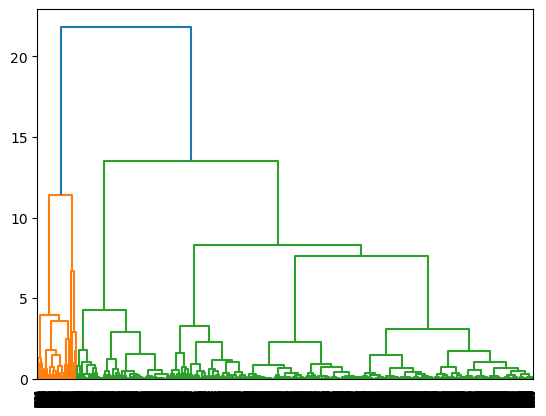

In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

mergings = linkage(cluster_df_scaled, method='ward') 
dendrogram(mergings)
plt.show()

# Based on the dendrogram, the optimal clusters seems to be 3 or 4

## Generating cluster labels with Kmeans vs Agglomerative

We'll use two models to generate cluster labels and then evaluate them.

In [44]:
kmeans = KMeans(n_clusters=4, random_state=42)
y_pred = kmeans.fit_predict(cluster_df_scaled)
print('Kmeans silhouette score:', silhouette_score(cluster_df_scaled, y_pred))

agglo = AgglomerativeClustering(n_clusters=4)
y_pred2 = agglo.fit_predict(cluster_df_scaled)
print('Agglomerative silhouette score:', silhouette_score(cluster_df_scaled, y_pred2))


Kmeans silhouette score: 0.4832866560244484
Agglomerative silhouette score: 0.45308999895905777


In [45]:
# Let's try k = 3

kmeans = KMeans(n_clusters=3, random_state=42)
y_pred = kmeans.fit_predict(cluster_df_scaled)
print('Kmeans silhouette score:', silhouette_score(cluster_df_scaled, y_pred))

agglo = AgglomerativeClustering(n_clusters=3)
y_pred2 = agglo.fit_predict(cluster_df_scaled)
print('Agglomerative silhouette score:', silhouette_score(cluster_df_scaled, y_pred2))



Kmeans silhouette score: 0.4533756682367874
Agglomerative silhouette score: 0.4469150692246973


In [46]:
# Let's cluster to 3 segments, because we want to control the size of highest priority segment
# The difference in their silhouette scores is only 3%

k = 3
kmeans = KMeans(n_clusters=k, random_state=42) 
labels = kmeans.fit_predict(cluster_df_scaled)

print('Silhouette score', silhouette_score(cluster_df_scaled, labels))

default_df['SEGMENT'] = labels

# Export default_df out as csv, so that we can use tableau for easier visualization
# default_df.to_csv('default_df.csv', index=False)

Silhouette score 0.4533756682367874


## Extracting insights based on cluster labels

Highest default importance segment: SEGMENT 2
Size of segment: 5.933333333333334 %
Features used for clustering: ['DEFAULT_IMPORTANCE', 'LIMIT_BAL']
Weights: [4 1]


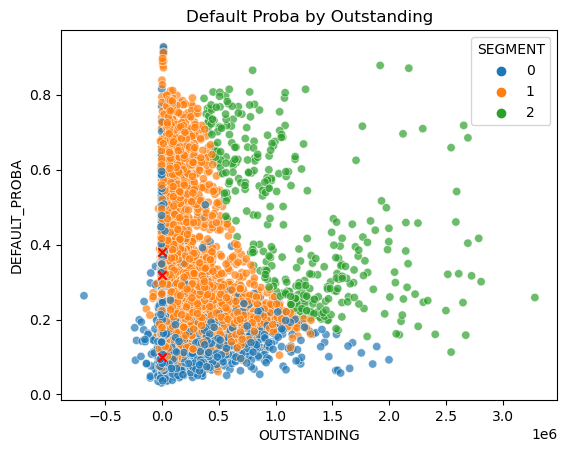

In [47]:
# group by segments
segment_groups = default_df.groupby(by='SEGMENT')

# Get segment with highest default importance
highest_segment = np.argmax(segment_groups['DEFAULT_IMPORTANCE'].mean())
print('Highest default importance segment: SEGMENT', highest_segment)

# Get size of segment
print('Size of segment:', segment_groups.get_group(highest_segment).count()[0] / default_df.shape[0] * 100, '%')

print('Features used for clustering:', cols_for_clustering)
print('Weights:', weights)

# Plot scatterplot of segments
sns.scatterplot(data=default_df, x='OUTSTANDING', y='DEFAULT_PROBA', hue='SEGMENT', palette='tab10', alpha=0.7);

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='x',);
plt.title('Default Proba by Outstanding');

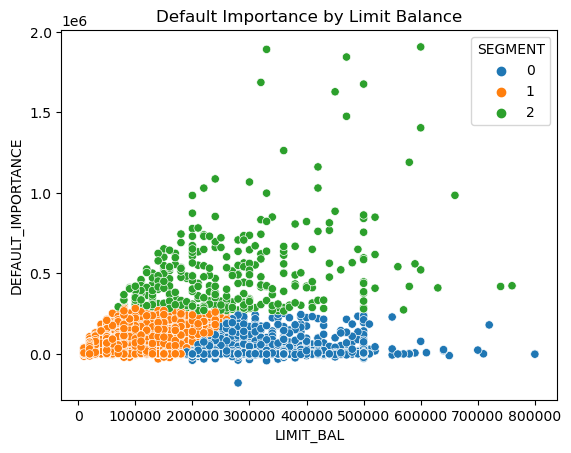

In [48]:
# Plot scatterplot of segments
sns.scatterplot(data=default_df, x='LIMIT_BAL', y='DEFAULT_IMPORTANCE', hue='SEGMENT', palette='tab10');
plt.title('Default Importance by Limit Balance');


# Plot centroids
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='x',);

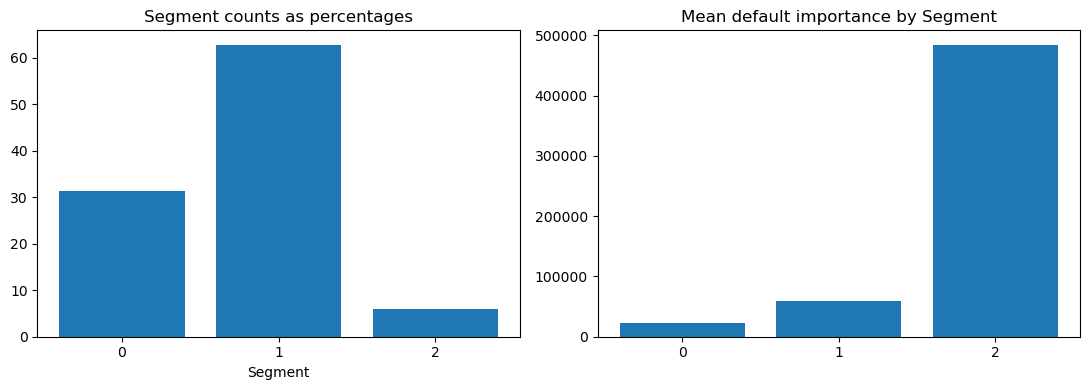

In [49]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.bar(segment_groups['ID'].count().keys(), segment_groups['ID'].count().values/segment_groups['ID'].count().sum()*100)
plt.xticks(range(k))
plt.xlabel('Segment')
plt.title('Segment counts as percentages');

segment_groups['ID'].count()

plt.subplot(1,2,2)
plt.bar(range(k), segment_groups['DEFAULT_IMPORTANCE'].mean())
plt.xticks(range(k))
plt.title('Mean default importance by Segment');

plt.tight_layout()
# default importance is determined by outstanding * default probability

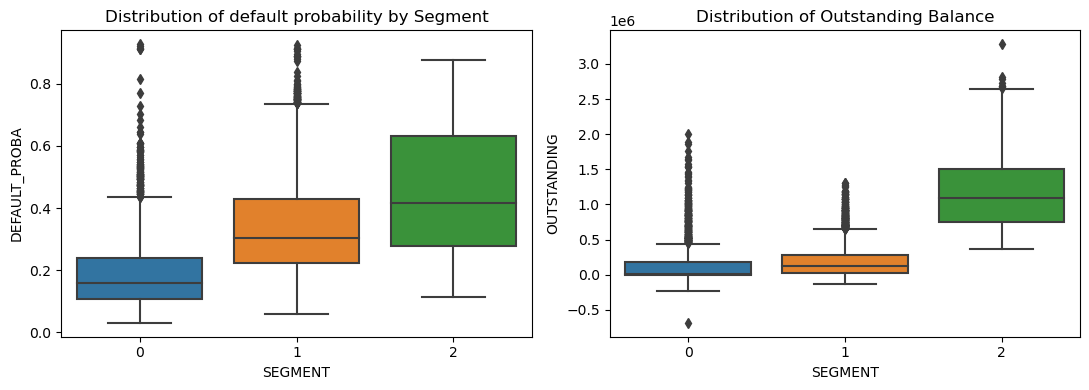

In [50]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='DEFAULT_PROBA', data=default_df) 
plt.title('Distribution of default probability by Segment');
segment_groups['DEFAULT_PROBA'].mean().round(2)

plt.subplot(1,2,2)
sns.boxplot(x='SEGMENT', y='OUTSTANDING', data=default_df) 
plt.title('Total bill amount for each segment');
plt.title('Distribution of Outstanding Balance');

plt.tight_layout()

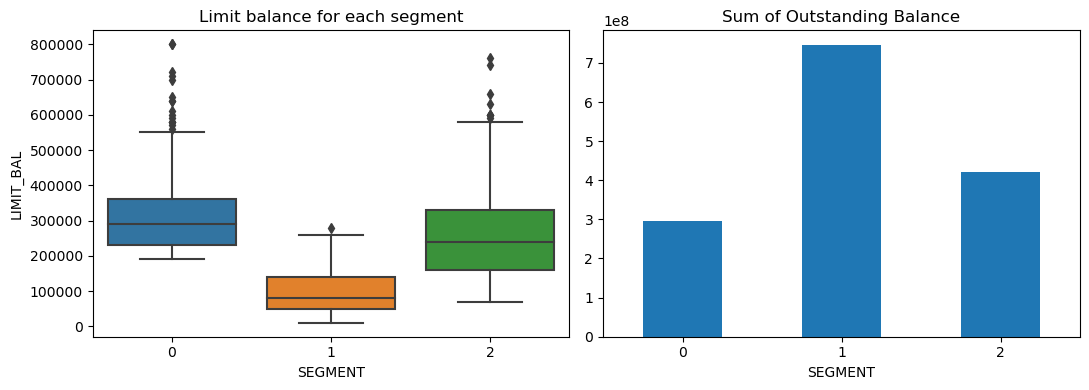

In [51]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='LIMIT_BAL', data=default_df, palette='tab10') 
plt.title('Limit balance for each segment');

plt.subplot(1,2,2)
segment_groups['OUTSTANDING'].sum().plot(kind='bar', rot=0)
plt.title('Sum of Outstanding Balance');

plt.tight_layout()

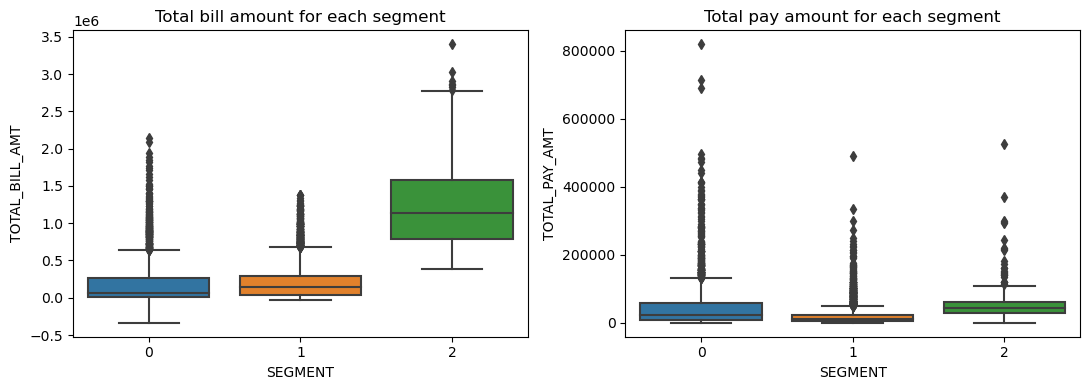

In [52]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.boxplot(x='SEGMENT', y='TOTAL_BILL_AMT', data=default_df) 
plt.title('Total bill amount for each segment');

plt.subplot(1,2,2)
sns.boxplot(x='SEGMENT', y='TOTAL_PAY_AMT', data=default_df, palette='tab10') 
plt.title('Total pay amount for each segment');

plt.tight_layout()

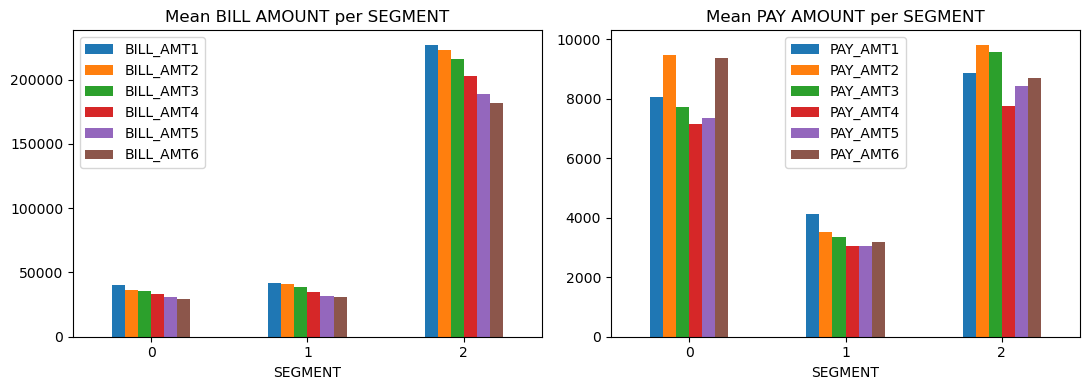

In [53]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
bill_amt_mean = segment_groups[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean()
bill_amt_mean.plot(kind='bar', ax=plt.gca(), rot=0)
plt.title('Mean BILL AMOUNT per SEGMENT');

plt.subplot(1,2,2)
pay_amt_mean = segment_groups[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean()

pay_amt_mean.plot(kind='bar', ax=plt.gca(), rot=0)
plt.title('Mean PAY AMOUNT per SEGMENT');

plt.tight_layout()

# the high risk/high default importance group has the highest mean bill amount in past 6 months.

#### Highest default importance segment has the highest mean bill amount

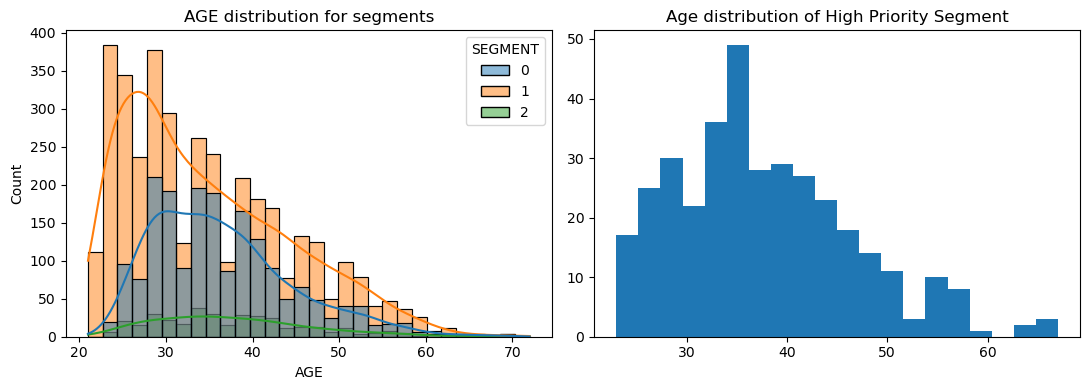

In [54]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.histplot(data=default_df, x="AGE", hue="SEGMENT", multiple="layer", kde=True, palette='tab10', bins=30)
plt.title('AGE distribution for segments');

plt.subplot(1,2,2)
segment_groups.get_group(highest_segment)['AGE'].hist(bins=20)
plt.title(f'Age distribution of High Priority Segment');

plt.grid(False)
plt.tight_layout()

# Age distribution mainly between 21 to 55

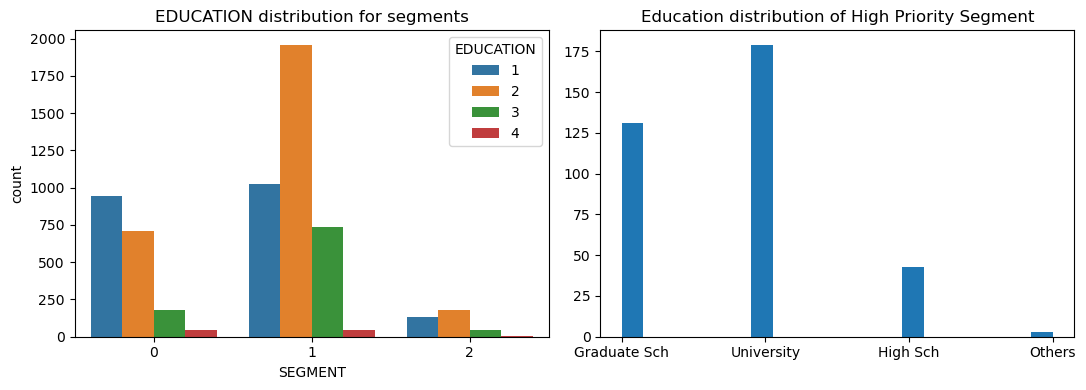

In [55]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.countplot(data=default_df, x="SEGMENT", hue="EDUCATION")
plt.title('EDUCATION distribution for segments');

plt.subplot(1,2,2)
segment_groups.get_group(highest_segment)['EDUCATION'].hist(bins=20)
plt.xticks([1,2,3,4], ['Graduate Sch', 'University', 'High Sch', 'Others'])
plt.title(f'Education distribution of High Priority Segment');

plt.grid(False)
plt.tight_layout()

# (1 = graduate school; 2 = university; 3 = high school; 4 = others)

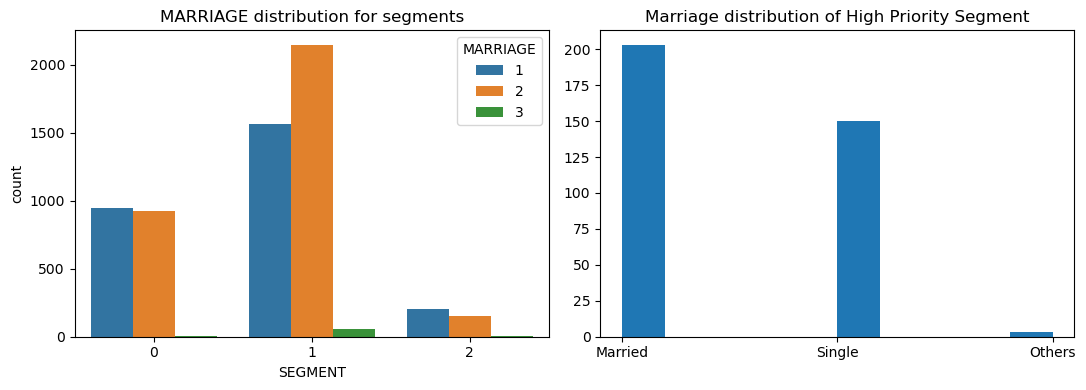

In [56]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.countplot(data=default_df, x='SEGMENT', hue="MARRIAGE")
plt.title('MARRIAGE distribution for segments');

plt.subplot(1,2,2)
segment_groups.get_group(highest_segment)['MARRIAGE'].hist(bins=10)
plt.xticks([1,2,3], ['Married', 'Single', 'Others'])
plt.title(f'Marriage distribution of High Priority Segment');

plt.grid(False)
plt.tight_layout()
# Marital status (1 = married; 2 = single; 3 = others)
# Compared to other segments, more married than singles

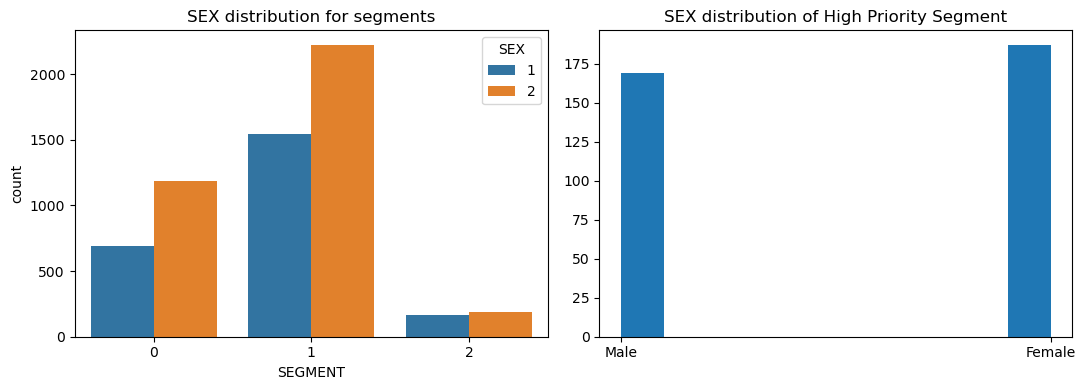

In [57]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
sns.countplot(data=default_df, x="SEGMENT", hue="SEX")
plt.title('SEX distribution for segments');

plt.subplot(1,2,2)
segment_groups.get_group(highest_segment)['SEX'].hist(bins=10)
plt.xticks([1,2], ['Male', 'Female'])
plt.title(f'SEX distribution of High Priority Segment');

plt.grid(False)
plt.tight_layout()

# Overall population has more females than males

# Demographics of 3 segments:

By order of default importance (default probability * outstanding amount):
Segment 2, Segment 1, Segment 0

#### Seg 2 (Highest priority: high outstanding, high default proba)
- 6% of all segments/population
- high default proba, High outstanding, 
- low-high limit balance, high default importance
- highest median default proba
- highest total bill amount (by median and distribution)
- highest mean bill amount and mean payment amt
- Age distribution: Right-skewed with bulk of ages in 20-45
- Education distribution: University, Grad school, high school (Similar with Segment 1)
- Marriage distribution: More married than singles (Different from other segment 1)
- Sex distribution: More female than male (Same for all segments, reflective of total population)

#### Seg 1 (middle segment: low limit balance, high default proba)
- <mark>60% of all segments/population (too many people to target, unless resources allow)</mark>
- high default proba, low outstanding balance but not lowest
- low limit balance, low default importance
- middle median default proba
- middle total bill amount (by median)
- low mean bill, lowest mean payment
- Education distribution:  University, Grad school, high school (Similar with Segment 0)
- Marriage distribution: More singles than married
- Sex distribution: More female than male (Same for all segments, reflective of total population)

#### Seg 0 (lowest segment: lowest outstanding, low default proba)
- 34% of all segments/population
- low default proba, lowest outstanding balance
- high limit balance, low default importance
- lowest median default proba
- lowest total bill amount (by median, with some outliers above Seg 1)
- low mean bill, high mean payment
- Education distribution: Grad school, University, high school (has more higher education)
- Marriage distribution: Slightly more married than singles
- Sex distribution: More female than male (Same for all segments, reflective of total population)





# Highest segment's outstanding balance captured

In [58]:
# Get the highest segment
highest_seg_df = default_df.query('SEGMENT == @highest_segment') 

# Num of users in segment
num_seg_users = highest_seg_df.count()[0]
print('Num of users in segment:', num_seg_users)

# % of users in segment compared to total
print('Segment as % of test set:', num_seg_users / default_df.count()[0] * 100 , '%')

print('---------------')

# Num of users in segment that will default
num_seg_users_default = highest_seg_df.query('`default payment this month` == 1').count()[0]
print('Num of users in segment that will default:', num_seg_users_default)

# Users in highest segment that are correctly detected by model 1 to default
num_detected = highest_seg_df.query('DEFAULT_PROBA > 0.5 & `default payment this month` == 1').count()[0]
print('Num of users detected:', num_detected)

print('% default users detected:', round(num_detected/num_seg_users_default * 100, 2), '%')

Num of users in segment: 356
Segment as % of test set: 5.933333333333334 %
---------------
Num of users in segment that will default: 139
Num of users detected: 92
% default users detected: 66.19 %


In [59]:
# False positives, predicted users in segment that won't default
false_positives = highest_seg_df.query('DEFAULT_PROBA > 0.5 & `default payment this month` == 0').count()[0]
print('Num of false positives:', false_positives)

print('% false positives in segment:', round(false_positives/num_seg_users * 100, 2), '%')


Num of false positives: 62
% false positives in segment: 17.42 %


In [60]:
# Segment outstanding 
seg_debt = highest_seg_df['OUTSTANDING'].sum()
print('Segment outstanding: $', format(seg_debt, ','))

# % Segment outstanding over overall, only count positives
all_debt = default_df[default_df['OUTSTANDING'] > 0]['OUTSTANDING'].sum()
print('% of all outstanding: ', round(seg_debt / all_debt * 100, 2), '%' )


# Segment outstanding that will truly default 
seg_debt_defaulted = highest_seg_df.query('`default payment this month` == 1')['OUTSTANDING'].sum()
print('Segment outstanding that default: $', format(seg_debt_defaulted, ',') )

# Overall outstanding that will truly default
all_default = default_df.query('`default payment this month` == 1')['OUTSTANDING'].sum()
print('Total default: $', format(all_default, ',') )

# % Segment defaults of total defaults
print('Segment default as % of total default:', round(seg_debt_defaulted/all_default * 100, 2), '%')



Segment outstanding: $ 422,145,887
% of all outstanding:  28.68 %
Segment outstanding that default: $ 144,825,173
Total default: $ 325,344,600
Segment default as % of total default: 44.51 %


In [61]:
# Columns used
print('Columns for clustering:',cols_for_clustering)

# Weights used
print('Weights:', weights)

Columns for clustering: ['DEFAULT_IMPORTANCE', 'LIMIT_BAL']
Weights: [4 1]


# Conclusion

By using model 1 for predicting default probabilities and model 2 for clustering high priority segments for targeting, 

- <mark>Our high priority segment is 5.9% of test set, covers 28.68% of all outstanding balance, and 44.51% of all defaulting outstanding.</mark>

Limitations: 
- We are using a test size of 0.2 (20%) of the whole population for testing predicted probabilities and clustering. Test size has same proportion of defaults/non-defaults as total dataset, but it might not be representative of it.


# Suggestions for future improvements

- Improve predictive model 1 at predicting default probabilities (feature engineering or more data/features)
- Or lower the threshold of 0.5 (for default proba) to capture more defaulters?
- Gather more data that can improve segment clustering model 2, for e.g. data on user responsiveness to previous communications on repayment. So that we can separate responsive versus non-responsive users into segments for targeting.

# Another method for targeted collection of outstanding balance

- Sort users by default importance, with highest ones at the top.
- Calculate % of default outstanding amount at each percentile
- Calculate % of outstanding amount at each percentile
- Plot each percentile, see which percentile covers high % of outstanding amount


In [62]:
# Order our test set by default importance

sorted_df = default_df.sort_values(by='DEFAULT_IMPORTANCE', ascending=False)
sorted_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,...,PAY_AMT6,TOTAL_BILL_AMT,TOTAL_PAY_AMT,TOTAL_PAY/TOTAL_BILL,PAY_AMT1/BILL_AMT1,default payment this month,DEFAULT_PROBA,OUTSTANDING,DEFAULT_IMPORTANCE,SEGMENT
15593,15594,600000,1,1,1,53,458652,467150,458862,469703,...,21000,2742479,88000,0.032088,0.037065,1,0.718087,2654479,1906146.43,2
4336,4337,330000,2,2,1,39,377779,372355,365250,358145,...,0,2171866,0,0.000000,0.000000,1,0.870695,2171866,1891032.60,2
27263,27264,470000,1,3,2,37,519901,499024,494290,470617,...,13600,2772282,80800,0.029146,0.000000,1,0.684940,2691482,1843504.91,2
13561,13562,320000,1,1,1,46,339202,337495,325700,313988,...,12165,1961056,40965,0.020889,0.014740,1,0.878016,1920091,1685870.15,2
29605,29606,500000,1,1,1,37,474934,507062,491956,430637,...,14113,2637882,94207,0.035713,0.084273,0,0.658657,2543675,1675408.47,2


In [63]:
# Similar to gain lift table, but adapt it for outstanding balance at every decile

rows = []

for group in np.array_split(sorted_df, 100): # use 10 to calculate for every 10 percentile
    default_ct = group[group['default payment this month'] == 1].count()[0]
    num = len(group)
    
    # some outstanding are negative because payment more than bill amount, we will not include those
    default_amt = group.query('`default payment this month` == 1 & OUTSTANDING > 0')['OUTSTANDING'].sum()
    outstanding_amt = group.query('OUTSTANDING > 0')['OUTSTANDING'].sum()
    rows.append({'NumRows': num, 'Events': default_ct,  'DEFAULT_AMT': default_amt, 'OUTSTANDING_AMT': outstanding_amt})

rows_df = pd.DataFrame(rows)

# Create percentiles based on no. of rows (note: rows  = users)
rows_df['CumRows'] = rows_df['NumRows'].cumsum()
rows_df['PercentDataset'] = (rows_df['CumRows'] / rows_df['NumRows'].sum() * 100).round(2)

# Calculate the cumulative default outstanding balance at each percentile
rows_df['DEFAULT_AMT_CUM'] = rows_df['DEFAULT_AMT'].cumsum()
total_default_amt = rows_df['DEFAULT_AMT'].sum()
rows_df['DEFAULT_CUM_PERCENT'] = (rows_df['DEFAULT_AMT_CUM'] / total_default_amt * 100).round(2)

# Calculate the cumulative outstanding balance at each percentile
rows_df['OUTSTANDING_AMT_CUM'] = rows_df['OUTSTANDING_AMT'].cumsum()
total_outstanding_amt = rows_df['OUTSTANDING_AMT'].sum()
rows_df['OUTSTANDING_CUM_PERCENT'] = (rows_df['OUTSTANDING_AMT_CUM'] / total_outstanding_amt * 100).astype(int)

rows_df

,NumRows,Events,DEFAULT_AMT,OUTSTANDING_AMT,CumRows,PercentDataset,DEFAULT_AMT_CUM,DEFAULT_CUM_PERCENT,OUTSTANDING_AMT_CUM,OUTSTANDING_CUM_PERCENT
0,60,27,45171814,107441783,60,1.0,45171814,13.83,107441783,7
1,60,24,25148010,77469466,120,2.0,70319824,21.53,184911249,12
2,60,21,21953046,69514903,180,3.0,92272870,28.25,254426152,17
3,60,28,24144754,56761693,240,4.0,116417624,35.64,311187845,21
4,60,22,13814304,52336047,300,5.0,130231928,39.87,363523892,24
...,...,...,...,...,...,...,...,...,...,...
95,60,6,0,0,5760,96.0,326607589,100.00,1472064421,100
96,60,10,0,0,5820,97.0,326607589,100.00,1472064421,100
97,60,8,0,0,5880,98.0,326607589,100.00,1472064421,100
98,60,12,0,0,5940,99.0,326607589,100.00,1472064421,100


In [64]:
# Check default percentages and amounts at 6% of dataset
rows_df.iloc[5]

# DEFAULT_CUM_PERCENT 44.5%
# OUTSTANDING_CUM_PERCENT 28.0%

# DEFAULT_AMT_CUM            145,575,900
# OUTSTANDING_AMT_CUM        421,202,800

NumRows                    6.000000e+01
Events                     1.900000e+01
DEFAULT_AMT                1.534395e+07
OUTSTANDING_AMT            5.767890e+07
CumRows                    3.600000e+02
PercentDataset             6.000000e+00
DEFAULT_AMT_CUM            1.455759e+08
DEFAULT_CUM_PERCENT        4.457000e+01
OUTSTANDING_AMT_CUM        4.212028e+08
OUTSTANDING_CUM_PERCENT    2.800000e+01
Name: 5, dtype: float64

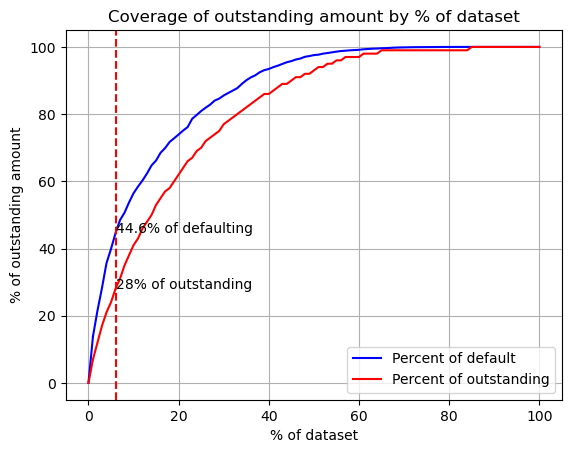

In [65]:
# Plot the cumulative default percentage and cumulative outstanding percentage

plt.plot([0, rows_df['PercentDataset'].iloc[0]], [0, rows_df['DEFAULT_CUM_PERCENT'].iloc[0]], color='b')
plt.plot([0, rows_df['PercentDataset'].iloc[0]], [0, rows_df['OUTSTANDING_CUM_PERCENT'].iloc[0]], color='r')

plt.plot(rows_df['PercentDataset'], rows_df['DEFAULT_CUM_PERCENT'], color='b', label='Percent of default')
plt.plot(rows_df['PercentDataset'], rows_df['OUTSTANDING_CUM_PERCENT'], color='r', label='Percent of outstanding')

plt.grid(True)
plt.title('Coverage of outstanding amount by % of dataset');
plt.xlabel('% of dataset')
plt.ylabel('% of outstanding amount');

plt.axvline(6, linestyle='--', color='r')
plt.text(6, 44.6, '44.6% of defaulting')
plt.text(6, 28, '28% of outstanding')
plt.legend();



Clustering algo's high segment covers 5.9% of test set, covers 28.68% of all outstanding balance, and 44.51% of all defaulting outstanding.

<mark>Using this method, at 6% of dataset, it covers 28% of all outstanding balance and 44.6% of defaulting amount.</mark>

It's a close fight. But this method has better utility because we can manually adjust how many percent of dataset to target, in order to cover any percentage of defaulting balance. 



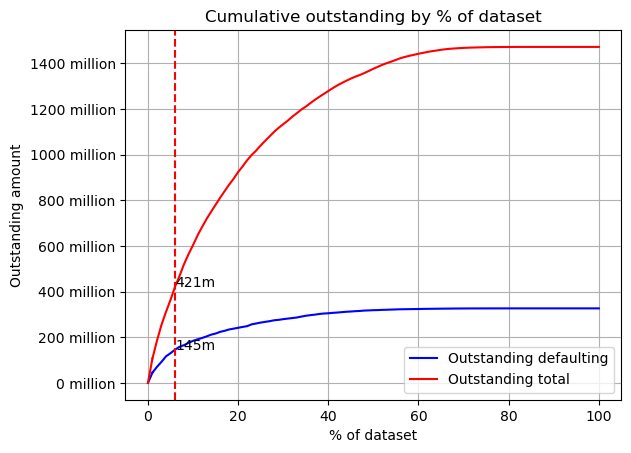

In [66]:
# Plot the cumulative default amounts and cumulative outstanding amounts each percentile

plt.plot([0, rows_df['PercentDataset'].iloc[0]], [0, rows_df['DEFAULT_AMT_CUM'].iloc[0]], color='b')
plt.plot([0, rows_df['PercentDataset'].iloc[0]], [0, rows_df['OUTSTANDING_AMT_CUM'].iloc[0]], color='r')

plt.plot(rows_df['PercentDataset'], rows_df['DEFAULT_AMT_CUM'], color='b', label='Outstanding defaulting')
plt.plot(rows_df['PercentDataset'], rows_df['OUTSTANDING_AMT_CUM'], color='r', label='Outstanding total')

plt.grid(True)
plt.title('Cumulative outstanding by % of dataset');
plt.xlabel('% of dataset')
plt.ylabel('Outstanding amount');

plt.legend();

import matplotlib.ticker as ticker

# Set the formatter for the y-axis tick labels
formatter = ticker.FuncFormatter(lambda x, pos: f"{int(x/1e6)} million")

# Apply the formatter to the y-axis ticks
plt.gca().yaxis.set_major_formatter(formatter)


# DEFAULT_AMT_CUM            145008291.0
# OUTSTANDING_AMT_CUM        421824730.0

plt.axvline(6, linestyle='--', color='r');
plt.text(6, 421*1e6, '421m')
plt.text(6, 145*1e6, '145m');

#### End of Notebook